# Real programmers are Not Afraid of Math

If you know calculus, great. If not, stop now, and run, don't walk, to your library or bookstore and beg, borrow, or buy a good calculus book. I recommend [Calculus the Easy Way](http://books.google.com/books?id=7fTV6dm2mM0C&lpg=PP1&dq=calculus%20the%20easy%20way&pg=PP1#v=onepage&q&f=false) by Douglas Downing. Come back when you understand what a derivative is, and know how to calculate some easy ones. Also at least know what an integral is, even if you don't know how to calculate any, and read about the fundamental theorem, which basically states that a derivative can be reversed and that it is useful to do so. Knowing at least a smidgen of calculus will serve you long after your robot has decided to take a swim in the pond. It opens up a whole new world of problems and solutions, and that is useful for you to have a feel for whether a problem is solvable even in principle, even if you don't know how to solve it.

I'll wait.

OK, are we ready to proceed? Let's move on then.


Kalman filter processes like to use the following model:

$$
\def\M#1{{[\mathbf{#1}]}}
\def\MM#1#2{{[\mathbf{#1}{#2}]}}
$$
$$
\begin{eqnarray*}
\vec{x}_i&=&\M A\vec{x}_{i-1}&+\vec{w}_{i-1} \\
\vec{z}_i&=&\M H\vec{x}_i&+\vec{v}_i
\end{eqnarray*}$$

Nonlinear Kalman Filter processes tend to use a different but related form:

$$\begin{eqnarray*}
\vec{x}_i&=&f(\vec{x}_{i-1})&+\vec{w}_{i-1} \\
\vec{z}_i&=&g(\vec{x}_i)&+\vec{v}_i
\end{eqnarray*}$$

where

* $f$ is the state transition function, which serves the same purpose as $\M A$. Given a previous state vector, the state transition function is used to transform it to the current state vector. So, this function takes a vector and returns a vector. This is more general than a pure matrix multiplication, and allows any kind of relation between this state and the next.
* $g$ is the observation function, which serves the same purpose as $\M H$. Given a state, the observation function is used to transform it to the observations. Likewise, a vector function with vector parameter.

HOWEVER

Most physical laws are in the form of vector differential equations, so we have:

$$\frac{d\vec{x}}{dt}=F(\vec{x},t)$$

where

* $F$ is the physical law function, which is used to calculate the derivative of the state. This is then integrated to get a new function which describes the state in a continuous manner from the initial state and the laws. This function of state versus time is called the trajectory, since one of the basic uses of this is describing the actual trajectory of something, like a planet, moon, or robot. Remember not to confuse $f$ with $F$. We almost never use or even have access to $f$.

Measurements are still taken at discrete instants. What we want is a way to shoehorn this continuous problem into a form suitable for the Kalman filter.

With sufficiently simple physics functions, you can crank out the integration as it shows in your textbooks and get the trajectory function directly. This is what [Newton invented calculus for](https://en.wikipedia.org/wiki/De_motu_corporum_in_gyrum) in the first place. However, for down-to-earth things like robots, the physics are usually too complicated to integrate directly. One of the things our filter will do for us is integrate numerically, so that we end up with (in principle) a list of times and the state vector for each time. This will be our trajectory function.

# Linearization

If you just want the recipe, skip a couple of sections.

Nonlinear problems are hard. In fact, they can't be done. So instead, we do a modified problem and hope that it is close enough. This is the part where everyone goes off on Taylor series and such. I will just talk somewhat informally.

First, most physical processes are smooth. No discontinuities and no corners. Just nice sweeping curves. If you look at any of these curves closely enough, the relative radius of curvature gets bigger and bigger, and any small section eventually appears linear if you zoom in on it enough.

In order to take advantage of this, you have to look at the right part of a curve. We need a reasonably accurate initial condition and a correct dynamics and kinematics model. Now we can use the derivative of the curve to find the general direction of motion. We use the initial condition estimate and model to create a reference trajectory. We end up not estimating the trajectory directly, but the divergence from the reference.

So, we need a replacement for $\M A$ and a way to update $\hat{x}_i$ and $\MM{P}{_i}$. The state vector is the easiest, so we'll talk about that. We know the physics model (If we don't, go find it!) so we can use it directly on our old estimate with numerical integration. I'll talk in detail about numerical integration in another post, but if you are a programmer, there is a good chance you have already written one. The simplest one is this simple:

* Find the rate of change of all the elements of the state vector at this point. That is, run $F(\hat{x}_{i-1})$, the physics function on the old estimate.
* Find the time step size. This is $\Delta t=t_i-t_{i-1}$.
* Multiply the rate of change vector by the time step size. This is how much the vector has changed over the step.
* Add the change to the old estimate to get the new estimate.

All numerical integrators are just improvements and refinements on this. If the time step is short enough, you can just do this. One simple refinement is to break the time step into smaller sub-steps and do the integration repeatedly.

Replacing $\M A$ is a bit harder. Skipping all the justifications and derivations, you need a physics matrix $\M \Phi$. Finding it will require cranking out a bunch of derivatives by hand or computer, or writing a numerical differentiator. Then with $\M \Phi$ in hand, you can numerically integrate to get $\M A$. This is the "linearization" process talked about in textbooks.

Matrix $\M \Phi$ is a Jacobian matrix, a kind of vector derivative. Instead of taking the derivative with respect to time as you may be accustomed to, you take the derivative of each component of the physics function with respect to each of the other components. You end up with a matrix, where for each cell, you have the derivative of the component that is this cell's row number, with respect to the component that is this cell's column number. If you want to, you can think of it as fitting tangent hyperplane to the physics function, in the same way that an ordinary derivative fits a tangent line to a 1D function. This hyperplane is flat, so this is why we call it "linearized". We then project this hyperplane out as far as we need it, and use it to transform an identity matrix from one place on the trajectory to $\M A$ on another. The math is pretty straight forward, it's just hard to imagine, especially with more than about 1 element in your state vector.

Once you have $\M A$ in hand, you can easily find $\MM{P}{_i^-}$ using the same formula as before.

We end up playing a similar Jacobian trick with the nonlinear observation. The Jacobian matrix of the observation function g(<x>) is dg/d<x>=[H]. No confusion with linear [H] because we use it the same way ever after.

# Extended Kalman Filter algorithm

To remember, the five equations of the linear Kalman filter are

$$\begin{eqnarray*}
\hat{x}^-_i &=&\M A\hat{x}_{i-1}\\
\MM{P}{^-_i}&=&\M A\MM{P}{_{i-1}}\M{A}^T+\M Q\\
\MM{K}{_i}  &=&\MM{P}{^-_i}\M{H}^T(\M H\MM{P}{^-_i}\M H^T+\M R)^{-1}\\
\hat{x}_i   &=&\hat{x}^-_i+\MM{K}{_i}(\vec{z}_i-\M H\hat{x}^-_i)\\
\MM{P}{_i}  &=&(\M 1-\MM{K}{_i}\M H)\MM{P}{^-_i}
\end{eqnarray*}$$

Equations 1 and 2 are called the time update while equations 3 through 5 are called the measurement update.

Plugging in what we have above into this form, we get the following. Don't panic too much, it will all make sense with a concrete example.

## Time update

1a. Calculate $\hat{x}^-_i$ by numerically integrating $\frac{d\vec{x}}{dt}=F(\vec{x}(t),t)$ from $t=t_{i-1}$ to $t=t_i$ with initial condition $\vec{x}(t_{i-1})=\hat{x}_{i-1}$

1b. Calculate $\MM{A}{(t_i,t_{i-1})}$ by numerically integrating $\frac{d\M{A}}{dt}=\MM{\Phi}{(\vec{x}(t),t)}\MM{A}{(t,t_{i-1})}$ from $t=t_{i-1}$ to $t_i$ with initial condition $\MM{A}{(t_{i-1},t_{i-1})}=\M 1$

Basically these integrations cover the time from one step to the next, generate our $\M A$ for us, and turn this from a continuous time problem back into a step problem like we had before. We do these integrations numerically, interleaved, and in lockstep, so that we can use the intermediate result $\vec{x}(t)$ from 1a where we need it in 1b.

1c. $\hat{X}^-_i=\vec{0}$

2 . $\MM{P}{^-_i}=\MM{A}{(t_i,t_{i-1})}\MM{P}{_{i-1}}\MM{A}{(t_i,t_{i-1})}^T+\M Q$

Equation 1c is where things start going different. We are estimating the deviation from the reference trajectory, but our update follows the reference trajectory perfectly, so our initial estimate of the deviation is zero. Equation 2 is exactly like the old form.


## Measurement update
 

3a. $\MM{H}{_i}=\frac{dg(\hat{x}^-_i,t_i)}{d\hat{x}^-_i}$ Linearized observation matrix is Jacobian of observation function

3b. $\MM{K}{_i}=\MM{P}{^-_i}\MM{H}{_i}^T(\MM{H}{_i}\MM{P}{^-_i}\MM{H}{_i}^T+\M R)^{-1}$ Kalman gain

4a. $\vec{Z}_i=\vec{z}_i-g(\hat{x}^-_i,t_i)$ Measurement deviation

4b. $\hat{X}_i=\hat{X}^-_i+\MM{K}{_i}(\vec{Z}_i-\MM{H}{_i}\hat{X}^-_i)$ Measurement update of state deviation

4c. $\hat{x}_i=\hat{x}^-_i+\hat{X}_i$ Update of reference state vector

5 . $\MM{P}{_i}=(\M 1-\MM{K}{_i}\MM{H}{_i})\MM{P}{^-_i}$ Measurement update of state covariance


My teacher called this is the extended Kalman filter, in distinction from the linearized Kalman filter, because the reference trajectory is updated every time around. To do the linearized filter, don't reset the state deviation to zero each time (just at the start) and don't add the state deviation to the reference state at the end. If the state deviation gets too big, you will need to do a rectification (equation 4c and 1c) every once in a while, but not at every measurement, where you do these things. The extended filter basically does rectification every time.

I actually don't see the point of not doing rectification every time, because otherwise, how do we know what the state estimate is? If you are running a control loop, you need the actual state estimate, so you need to do the addition in 4c anyway. Why not use it and set the deviation back to zero each time?

# Extended Kalman Filter for linear velocity model

Time for an example. We'll start really really simple, and just redo the linear velocity model.

First off, state vector. Basically the state vector is all the things that the system "remembers" about itself. Think about it as a simulation. Once we have a program, we run the simulation and freeze it at a certain point. What do we need to save so that when we restore, we have enough data to start the simulation back up? We'll use the cart on rails model as an example. We are working with a massive cart on smooth, level, perfectly frictionless rails. Therefore the cart is free to move in one dimension only. The very meaning of one dimension is that it takes only one number to describe the position, and we will call this number $p$. If we think of it as a function of time, we might say $p(t)$. We need $p$ in our state vector, but this does not yet completely describe the state. We also need to know the velocity. A cart at 4m down the track stopped is very different from a cart at 4m moving at 50m/s. As it turns out, this is all we need to know. This is all the cart "remembers" - everything else, such as our random gusts of wind, are instantaneous only. Any effect they have is only through changing the position and velocity. Therefore, $\vec{x}=\begin{bmatrix}p & v\end{bmatrix}^T$. Our state vector has two elements, $p$ (in units of meters from the origin, positive on one side and negative on the other) and $v$ (in units of meters per second, positive if moving one way and negative if the other).

Next, physics. We actually use Newton's first law here (normally problems start with the second law). The cart has no forces applied to it, so it continues in a straight line at constant speed. The derivative of the speed is zero (this is what constant speed means) and the derivative of the position is the speed, so we end up with this:

$$\begin{eqnarray*}
\frac{dv}{dt}&=&0\\
\frac{dp}{dt}&=&v\\
\frac{d\vec{x}}{dt}&=&\begin{bmatrix}x_v\\0\end{bmatrix}
\end{eqnarray*}$$

(An aside on vector notation. If the components of a vector $\vec{?}$ are named, I will specify the element named $@$ by $?_@$ . If the components are ordered, and they always are, I will call the first one $?[0]$, followed by $?[1]$ etc. Zero-based, like C. Note that we don't use $?_0$ which would be conventional math notation, because that conflicts with our use as a step index. So, for our state vector $\vec{x}$ above, we can talk about $x_p$, $x_v$, and note that $x[0]=x_p$. Vector components always have an order, but sometimes it is more clear to talk about the components by name if any, so I will freely use both notations. When I get to it, I will number matrix cells with two indexes, row first, then column, starting at 0. So, the upper-left cell of any matrix $\M ?$ is $?[0,0]$.)


Believe it or not, we are done with the physics function.

$$\begin{eqnarray*}
F(\vec{x})&=&\frac{d\vec{x}}{dt} \\
          &=&\begin{bmatrix}x_v \\ 0\end{bmatrix}
\end{eqnarray*}$$

Now for the observation function. The observation vector is a single number, the position along the track. So, we get

$$g(\vec{x})=x_p$$

Again, that's it.

Now for jacobians. We need a function that can calculate $\M \Phi$ given any $\vec{x}$, and to do this we need derivatives. We are going to do the derivatives once on paper, code them up in a function, and then that function will provide the actual numerical derivative whenever we need it.

Matrix $\M \Phi$ is a $2 \times 2$ matrix, since it needs to be compatible with $\M A$ (since we add $\M A$ and a fraction of $\M \Phi$ in the numerical integrator). There are only four elements, so we can go nice and slow. In the upper left cell of the matrix, we take the derivative of the zero component of the force function $F[0](\vec{x})=x_v$ with respect to the zero component of the state vector $x_p$ . Since this variable doesn't even occur in the formula, the derivative is zero and we have $\Phi[0,0]=0$. Next, in the upper right $[0,1]$ cell, we have component zero of the force function $F[0](\vec{x})=x_v$ still, but this time we are going with respect to the 1 component of the state vector $x_v$. The derivative of any variable with respect to itself is 1, so we get $\Phi[0,1]=1$. Bottom left cell $[1,0]$ uses $F[1](\vec{x})=0$ and $x[0]=x_p$ so we have $\Phi[1,0]=0$. To finish off, we have bottom right cell $[1,1]$ which uses $F[1](\vec{x})=0$ and $x[1]=x_v$ so $\Phi[1,1]=0$. As it happens this time, all the cells are constant, so our physics matrix function can just return a constant in response to any state vector 

$$\MM{\Phi}{(\vec{x})}=\begin{bmatrix}0 & 1 \\ 0 & 0\end{bmatrix}$$

for any $\vec{x}$. As we shall see in our next example, things are not always so easy.

The Jacobian for $g$ is even easier, but it is still a matrix. Any Jacobian of any vector parameter function with a vector return value has as many columns as the input vector has elements, and as many rows as the output vector has elements. So, in this case, 1 row by 2 columns. For $H[0,0]$, we use $g[0](\vec{x})=x_p$ and $x[0]=x_p$, so $H[0,0]=dx_p/dx_p=1$. For $H[0,1]$ we have $g[0](\vec{x})=x_p$ and $x[1]=x_v$, so $H[0,1]=dx_p/dx_v=0$

$$\M{H}=\begin{bmatrix}0 & 1\end{bmatrix}$$

To sum up, our problem is described as follows:


* State vector $\vec{x}=\begin{bmatrix}p \\ v\end{bmatrix}$
* Physics function $F(\vec{x})=\begin{bmatrix}x_v \\ 0\end{bmatrix}$
* Observation function $g(\vec{x})=x_p$
* Linearized physics matrix $\M \Phi=\begin{bmatrix}0 & 1 \\ 0 & 0\end{bmatrix}$
* Linearized observation matrix $\M H=\begin{bmatrix}1 & 0\end{bmatrix}$

Also, a word about a priori initial guesses. You will note that we always need an initial guess of our state vector at step 0 $\hat{x}_0$ as well as an initial guess of our uncertainty of our initial guess, $\MM{P}{_0}$. For some problems, it doesn't matter so much what the initial guess is, since the filter converges rapidly. Sometimes, though, it doesn't, and when this happens, the filter gets farther and farther from the correct answer instead of closer, and we say that the filter diverges. If this happens in a real vehicle, the thing may diverge from its intended course and converge with a wall, causing the parts of the vehicle to diverge from each other. Let's agree right now not to diverge. Your filter can handle the truth, as much truth as you can give it. Give it as good of an initial guess as possible.

# Filter code

The program is structured as follows. The driver function starts with a piece to simulate the cart. It will create one data point every 100ms for 10s, for a total of 100 points. Next we will add some noise to create the measurements. Then, we create the a priori initial guess.

Finally, we run the filter loop. Each iteration of the filter loop will process one observation and create one state estimate. The time stamp of this estimate is exactly the time of the measurement. The numerical integrators will be in line, instead of in a separate function to start with. Just to see how it's done, we will do a numerical integration time step of 1ms, so we need 100 loops to get from one measurement to the next.

All the other equations will be pretty much as written.

After we have run the filter loop, we will compare the estimates with the true noise-free state we started with.

<IPython.core.display.Javascript object>


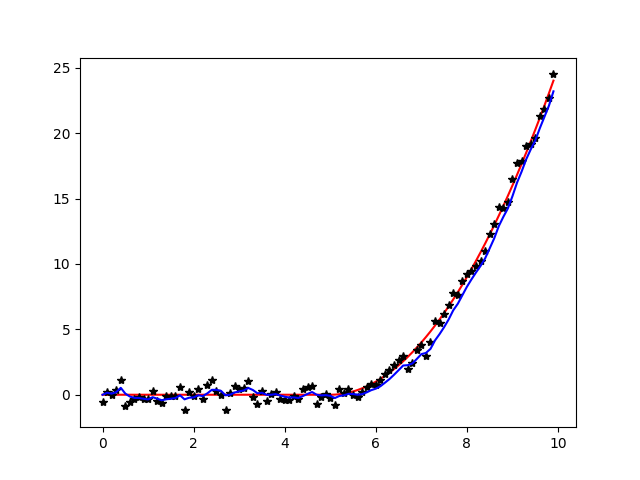

<IPython.core.display.Javascript object>


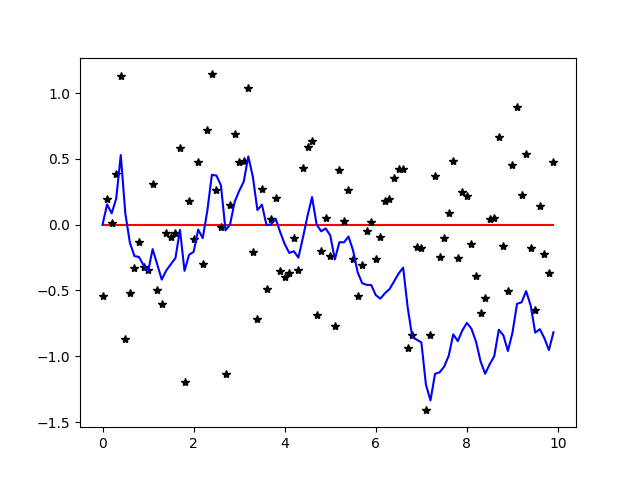

In [1]:
%matplotlib notebook
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from scipy.linalg import inv

def F(x):
    """
    Physics function F(<x>). Takes a state vector, returns the derivative of
    the state vector. Primary physics model definition
    """
    return np.array([[x[1,0]], [0]])

def Phi(x):
    """
    Physics matrix [Phi(<x>)]. Takes the state vector and returns the jacobian
    matrix. Secondary physics model definition, as it is derived from F() (on
    paper).
    """
    return np.array([[0, 1], [0, 0]])

def g(x):
    """
    Observation function g(<x>). Takes a state vector, returns an observation
    vector. Primary observation model definition
    """
    return x[0,0]

def H(x):
    """
    Observation matrix [Phi(<x>)]. Takes the state vector and returns the
    Jacobian matrix. Secondary observation model definition, as it is derived
    from g() (on paper).
    """
    return np.array([[1, 0]])

def _inv(x):
    """
    Matrix inverse which also handles scalars properly
    :param x:
    :return:
    """
    try:
        return inv(x)
    except ValueError:
        return np.array([[1.0/x]])

def nonlinear_velocity(Q=None,sig_a=1,tag=None):
    # Simulated actual trajectory. Stopped at the origin for first five seconds,
    # then constant acceleration such that position reaches 25m after 10
    # seconds.

    t = np.arange(0, 10, 0.1)  # Timestamp of each measurement
    pt = np.hstack((np.zeros(50), np.arange(0, 5, 0.1) ** 2))  # True position

    # We want random noise, but the *same* random noise each time we run
    nr.seed(3217)
    R = 0.5 ** 2  # Measurement noise covariance, 50cm on position
    pn = nr.randn(t.size) * np.sqrt(R)  # Position noise, standard deviation of 10cm.

    dt=0.1
    if Q is None:
        Q = np.array([[dt**4/4, dt**3/2], [dt**3/2, dt**2]])*sig_a**2  # Process noise covariance
    z = pt + pn  # Observations

    xh_0 = np.array([0, 0])  # Initial state vector guess
    xh = np.zeros((xh_0.size, t.size))  # History of all estimates (starts as initial estimate)
    xh[:, 0] = xh_0
    P_0 = np.array([[1, 0], [0, 1]])  # Initial state vector uncertainty, 1m in position and 1m/s in velocity
    P = np.zeros((xh_0.size, xh_0.size, t.size))  # History of all estimate covariances
    P[:, :, 0] = P_0

    nstep=100
    I=np.eye(xh_0.size)
    for i in range(1, 100):
        # Pull previous estimate from histories
        xh_im1 = xh[:, i - 1].reshape(2,1)  # Previous extimate <x^_{i-1}>
        P_im1 = P[:, :, i - 1]  # Previous covariance <P^_{i-1}>

        # One numerical integrator for both 1A and 1B, so that 1B can use the
        # intermediate results of 1A.
        ddt = dt/nstep
        xh_im = xh_im1  # To become updated state estimate <x^_i->
        A = np.copy(I)  # The thing we integrate in 1b, will be come [A]
        for j in range(nstep):
            # 1a. Use numerical integration to update state vector through time from
            # <x^_{i-1}> to <x^_i->
            xh_im = xh_im + ddt * F(xh_im)
            # 1b. Use numerical integration to update [A]
            A = A + ddt * (Phi(xh_im) @ A)
        # 1c, state deviation estimate
        Xh_im = np.zeros(xh_im.shape)
        # 2. Projected covariance estimate
        P_im = A @ P_im1 @ A.T + Q
        # 3a. Linearized observation matrix
        H_i = H(xh_im)
        # 3b. Kalman gain
        K = P_im @ H_i.T @ _inv(H_i @ P_im @ H_i.T + R)
        # 4a. Measurement deviation
        Z_i = z[i] - g(xh_im)
        # 4b. Measurement update of state deviation
        Xh_i = Xh_im + K @ (Z_i - H_i @ Xh_im)
        # 4c. Update of reference state vector
        xh_i = xh_im + Xh_i
        # 5. Measurement update of state covariance
        P_i = (I - K @ H_i) @ P_im

        # Record the current estimates
        xh[:, i] = xh_i.reshape(2)
        P[:, :, i] = P_i

    #Return what is needed in order to make the plots
    return (t,pt,z,xh[0,:])

#Run with the *wrong* nonphysical Q
(tw,ptw,zw,xhw)=nonlinear_velocity(Q=np.array([[0.01,0],[0,0.01]]),tag="Qw")
plt.figure("Qwrong Velocity filter")
plt.plot(tw, ptw, 'r-', tw, zw, 'k*', tw, xhw, 'b-')
plt.figure("Qwrong Residuals")
plt.plot(tw, ptw - ptw, 'r-', tw, zw-ptw, 'k*', tw, xhw-ptw, 'b-')
plt.show()


Hmm, not so good. The estimate starts lagging behind the truth, and never catches up. This is more because the model doesn't fit the actual cart (which in this case has a rocket on it which lights at $t$=5sec). If the model could not be improved, then we will have to sacrifice smoothness and increase the process noise. In this form, we had an arbitrary $\M Q$, which wasn't physically derived. We will try a different (larger) $\M Q$ which is derived from the sigma-acceleration model used in BeginnerKalman.

<IPython.core.display.Javascript object>


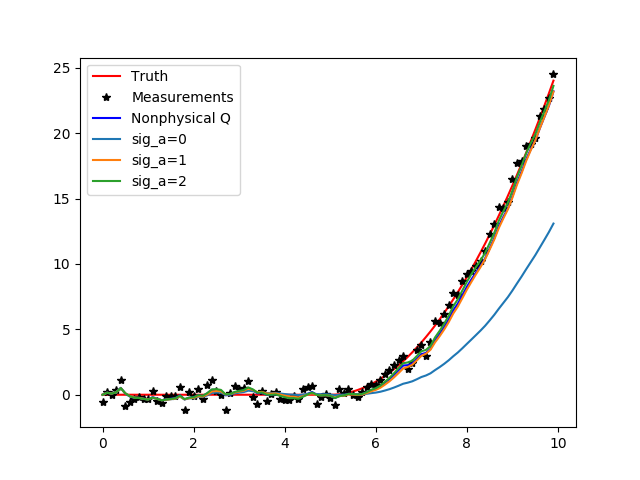

<IPython.core.display.Javascript object>


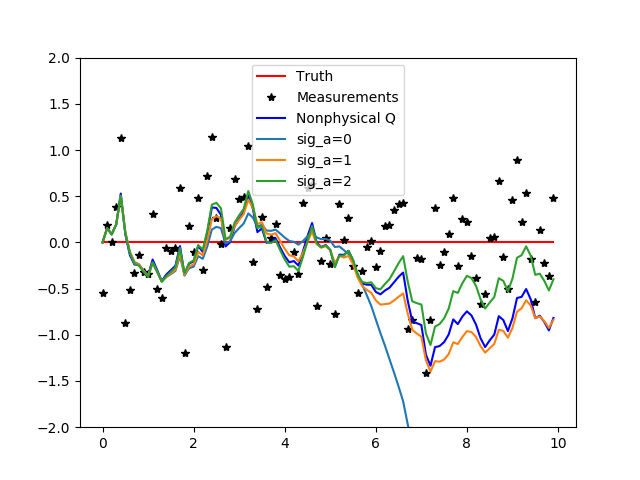

In [2]:
#Gradually increase process noise and plot each one
(t0,pt0,z0,xh0)=nonlinear_velocity(sig_a=0)
(t1,pt1,z1,xh1)=nonlinear_velocity(sig_a=1)
(t2,pt2,z2,xh2)=nonlinear_velocity(sig_a=2)
plt.figure("Velocity filter")
plt.plot(tw, ptw, 'r-',label='Truth')
plt.plot(tw, zw, 'k*',label='Measurements')
plt.plot(tw, xhw, 'b-',label='Nonphysical Q')
plt.plot(t0,xh0,label='sig_a=0')
plt.plot(t1,xh1,label='sig_a=1')
plt.plot(t2,xh2,label='sig_a=2')
plt.legend()
plt.figure("Residuals")
plt.plot(tw, ptw - ptw, 'r-',label='Truth')
plt.plot(tw, zw-ptw, 'k*',label='Measurements')
plt.plot(tw, xhw-ptw, 'b-',label='Nonphysical Q')
plt.plot(t0,xh0-pt0,label='sig_a=0')
plt.plot(t1,xh1-pt1,label='sig_a=1')
plt.plot(t2,xh2-pt2,label='sig_a=2')
plt.ylim(-2,2)
plt.legend()
plt.show()


The filter with no process noise is not able to track the proper value at all, of course. One would think that having a larger $\M Q$ would lead to less noise filtering but better average tracking of the true value, but that doesn't seem obvious in the data above. The green line with the largest $\M Q$ shows both better tracking of the truth, and not noticeably worse noise amplitude.